In [1]:
 TTree * tree = new TTree("tree","tree");

We define now the branches we want to read

In [2]:
 TString branchDescription("Type/C:RunNo/I:EvNo/I:E1/F:px1:py1:pz1:pt1:eta1:phi1:Q1/I:E2/F:px2:py2:pz2:pt2:eta2:phi2:Q2/I:M/F");

Read the tree from the text file

In [3]:
tree->ReadFile("dimuon_2-5Gev.csv",branchDescription,',');

In [4]:
tree->Print()

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :     2000 : Total =          178697 bytes  File  Size =          0 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :Type      : Type/C                                                 *
*Entries :     2000 : Total  Size=      14632 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :RunNo     : RunNo/I                                                *
*Entries :     2000 : Total  Size=       8634 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

We make now the histogram which we are going to fill with the tree data

In [5]:
h1 = new TH1D("h1","h1",60,2,5);

We will now the histogram using TTree::Draw with the invariant mass variable

In [6]:
tree->Draw("M >> h1");

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


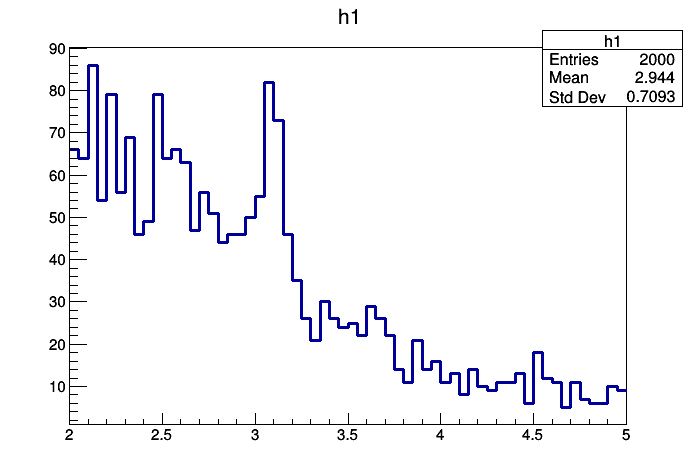

In [7]:
gPad->Draw()

We do first a Gaussian fit and then a background fit 

In [8]:
r1 = h1->Fit("gaus","S","",2.7,3.3);

 FCN=30.5527 FROM MIGRAD    STATUS=CONVERGED      90 CALLS          91 TOTAL
                     EDM=1.47351e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.64163e+01   3.30924e+00   9.59492e-03  -3.98835e-05
   2  Mean         2.96243e+00   3.07218e-02   2.42690e-05   4.63756e-03
   3  Sigma        3.05245e-01   4.90781e-02  -1.88765e-04   2.20343e-03


In [9]:
r2 = h1->Fit("expo","S +"); // use option + do add the bkg function to the plot

 FCN=146.856 FROM MIGRAD    STATUS=CONVERGED      49 CALLS          50 TOTAL
                     EDM=3.25003e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.11909e+00   8.60254e-02   1.37918e-04   3.36869e-03
   2  Slope       -8.40199e-01   2.82765e-02   4.53331e-05   1.05539e-02


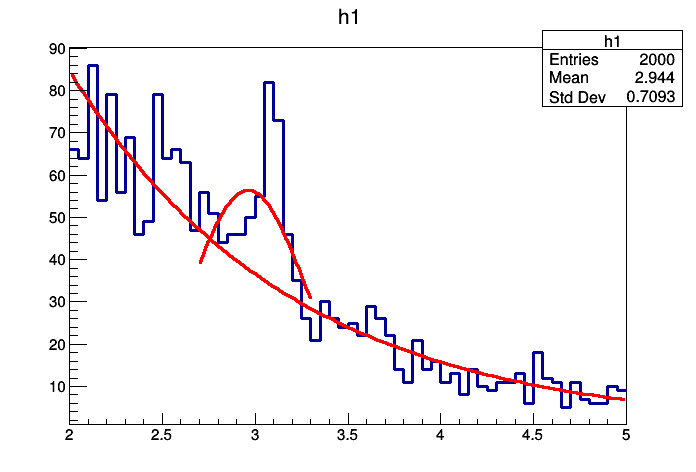

In [10]:
gPad->Draw();

we create the global fit function

In [11]:
f1 = new TF1("fitFunc","gaus(0)+expo(3)");

We set the initial function parameters

In [12]:
// parameters of first gaussian
f1->SetParameter(0,r1->Parameter(0));
f1->SetParameter(1,r1->Parameter(1));
f1->SetParameter(2,r1->Parameter(2));
// parameters of the exponential 
f1->SetParameter(3,r2->Parameter(0));
f1->SetParameter(4,r2->Parameter(1));
// set the parameter names
f1->SetParNames("A","Mean","Sigma","B","Slope");

now we do the global fit using Minuit2

In [13]:
ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");
auto result = h1->Fit(f1,"S L"); 
result->Print("V");


****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      39.0937
Chi2                      =      84.4604
NDf                       =           55
Edm                       =   5.7256e-08
NCalls                    =          222
A                         =       45.829   +/-   7.53359     
Mean                      =       3.0894   +/-   0.0101223   
Sigma                     =    0.0597861   +/-   0.0111565   
B                         =      6.10053   +/-   0.093544    
Slope                     =     -0.83212   +/-   0.0309807   

****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      39.0937
Chi2                      =      84.4604
NDf                       =           55
Edm                       =   5.7256e-08
NCalls                    =          222
A                         =       45.829   +/-   7.53359     
Mean                      =       3.0894   +/-   0.0101223   
Sigma       

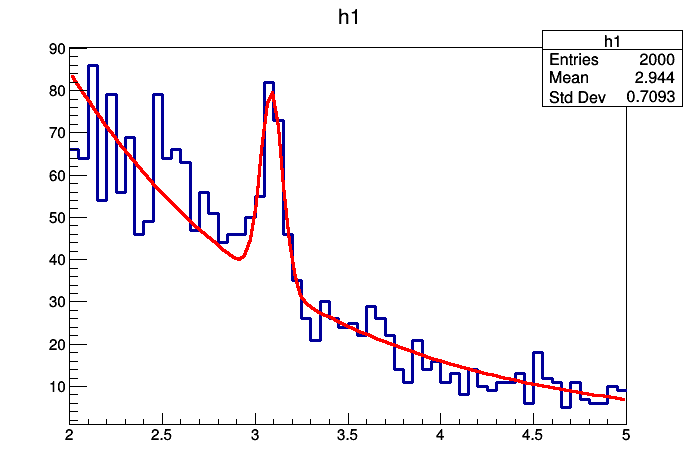

In [14]:
gPad->Draw()

Now we want to compute the number of signal events. We can do this by using error propagation from the Fit parameters.
Let's define first a function for the signal events 

In [15]:
TF1 * peakFunc = new TF1("peakFunc","gaus");

In [16]:
peakFunc->SetParameter(0, f1->GetParameter(0));
peakFunc->SetParameter(1, f1->GetParameter(1));
peakFunc->SetParameter(2, f1->GetParameter(2));

We get now the correlation matrix for the peak function parameter from the global correlation matrix from the fit

In [17]:
fitCovMatrix = result->GetCovarianceMatrix(); 
peakCovMatrix = fitCovMatrix.GetSub(0,2,0,2);

We can then call TF1::Integral to get the number of signal events and the TF1::IntegralError  to get the corresponding error

In [18]:
nsignal = peakFunc->Integral(0,10) / h1->GetBinWidth(1);
std::cout << "number of signal events = " << nsignal << std::endl;

number of signal events = 137.36


In [19]:
peakCovMatrix.Print()


3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |      56.76     0.01127    -0.05243 
   1 |    0.01127   0.0001025  -3.193e-05 
   2 |   -0.05243  -3.193e-05   0.0001245 



In [20]:
peakFunc->Print()

Formula based function:     peakFunc 
             peakFunc : gaus Ndim= 1, Npar= 3, Number= 100 
 Formula expression: 
	[Constant]*exp(-0.5*((x-[Mean])/[Sigma])*((x-[Mean])/[Sigma])) 


In [21]:
double * params  = peakFunc->GetParameters();
double * covArray = peakCovMatrix.GetMatrixArray();

In [22]:
nsignalError = peakFunc->IntegralError(0,10,params,covArray)/h1->GetBinWidth(2);
std::cout << "number of signal events = " << nsignal << " +/- " << nsignalError << std::endl;    

number of signal events = 137.36 +/- 21.0888


Now we do the same thing but using a new feature of ROOT, the TF1NormSum class which allows to sum two function using its normalization. 
By doing this the number of signal events are a parameter of the fit

In [23]:
TF1NormSum fnorm("gaus+expo",0,10);

In [24]:
fsum = new TF1("fsum", fnorm, 0, 10, fnorm.GetNpar());

In [25]:
// first parameters are the number of events: signal (gaussian) and backgorund (exponential)
fsum->SetParameter(0,100);
fsum->SetParameter(1,1000);                   
// shape parameters of first gaussian
fsum->SetParameter(2,r1->Parameter(1));
fsum->SetParameter(3,r1->Parameter(2));
// shape parameters of the exponential 
fsum->SetParameter(4,r2->Parameter(1));
fsum->SetParNames("Nsig","Nbkg","Mean","Sigma","Slope");

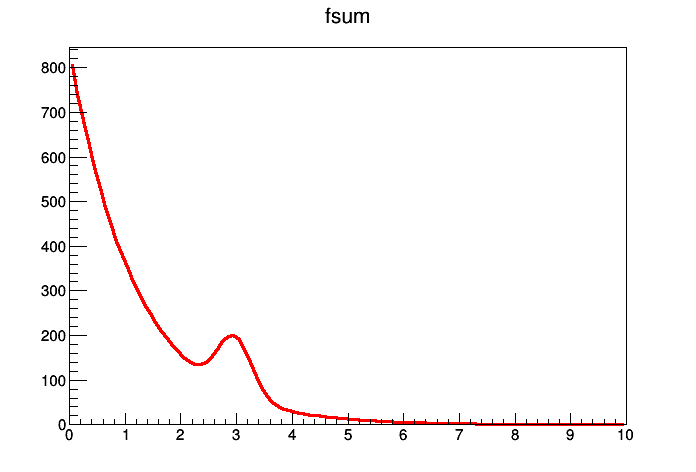

In [26]:
fsum->Draw(); gPad->Draw();

In [27]:
auto result2 = h1->Fit(fsum,"L S");


****************************************
Minimizer is Minuit2 / Migrad
MinFCN                    =      39.0937
Chi2                      =      84.4625
NDf                       =           55
Edm                       =  3.68862e-07
NCalls                    =          382
Nsig                      =      6.86788   +/-   1.05433     
Nbkg                      =      535.955   +/-   31.4058     
Mean                      =       3.0894   +/-   0.0101129   
Sigma                     =    0.0597901   +/-   0.0111573   
Slope                     =    -0.832107   +/-   0.0309828   


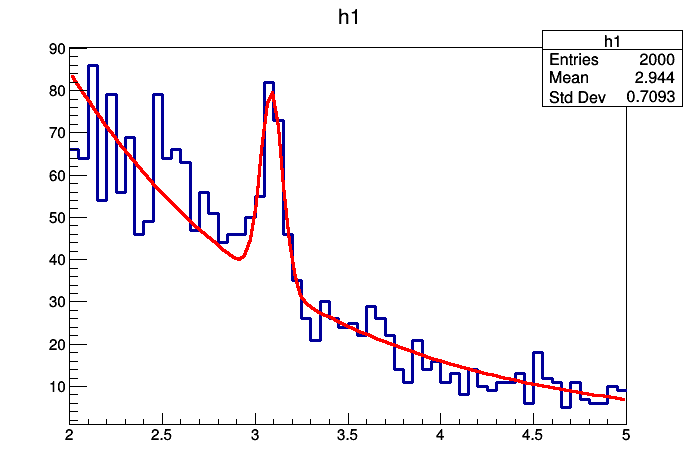

In [28]:
gPad->Draw();

In [29]:
std::cout << "Number of signal events = " << result2->Parameter(0)/h1->GetBinWidth(1) << " +/- " << result2->Error(0)/h1->GetBinWidth(1) << std::endl;

Number of signal events = 137.358 +/- 21.0865


Perform now a background only fit to compute the significance of the peak

In [ ]:
fsum->SetParameter(0,0);
fsum->FixParameter(0,0);

In [ ]:
auto result3 = h1->Fit(fsum,"L S");

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Hesse is not valid

 *** Break *** segmentation violation
 Generating stack trace...
 0x0000000109d4a134 in PyErr_WarnExplicit (in Python) + 143
 0x000000010b35ac87 in ErrorHandler (in libCore.so) (TError.cxx:251)
 0x000000010b35ad6b in Warning(char const*, char const*, ...) (in libCore.so) (TError.cxx:336)
 0x000000011c74d2dc in TFitResultPtr HFit::Fit<TH1>(TH1*, TF1*, Foption_t&, ROOT::Math::MinimizerOptions const&, char const*, ROOT::Fit::DataRange&) (in libHist.so) (memory:3954)
 0x000000011c74c2ee in ROOT::Fit::FitObject(TH1*, TF1*, Foption_t&, ROOT::Math::MinimizerOptions const&, char const*, ROOT::Fit::DataRange&) (in libHist.so) (HFitImpl.cxx:951)
 0x000000011c7f353f in TH1::Fit(TF1*, char const*, char const*, double, double) (in libHist.so) (TH1.cxx:3895)
 0x000000011fa8f070 in <unknown function>
 0x000000011fa8f0c0 in <unknown function>
 0x000000010ba8bc7e in cling::IncrementalExecutor::runStaticIn